In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Enter the stock ticker symbol (e.g., AAPL):  AAPL
Enter the start date (YYYY-MM-DD):  2000-01-01
Enter the end date (YYYY-MM-DD):  2020-01-01
Enter the initial investment amount ($):  10000



Fetching data for AAPL from 2000-01-01 to 2020-01-01...


[*********************100%***********************]  1 of 1 completed


Data download complete!

Backtesting the strategy...


=== Strategy Performance for AAPL ===
Initial Investment: $10,000.00
Final Portfolio Value: $485,140.63
Total Return: 4751.41%
Sharpe Ratio: 0.00 (Higher is better; >1 is considered good)
Max Drawdown: 0.62% (Maximum loss from a peak to a trough)
CAGR: 0.21 (Annualized growth rate over the period)

Prediction Accuracy: 44.12% (Correct buy/sell predictions)



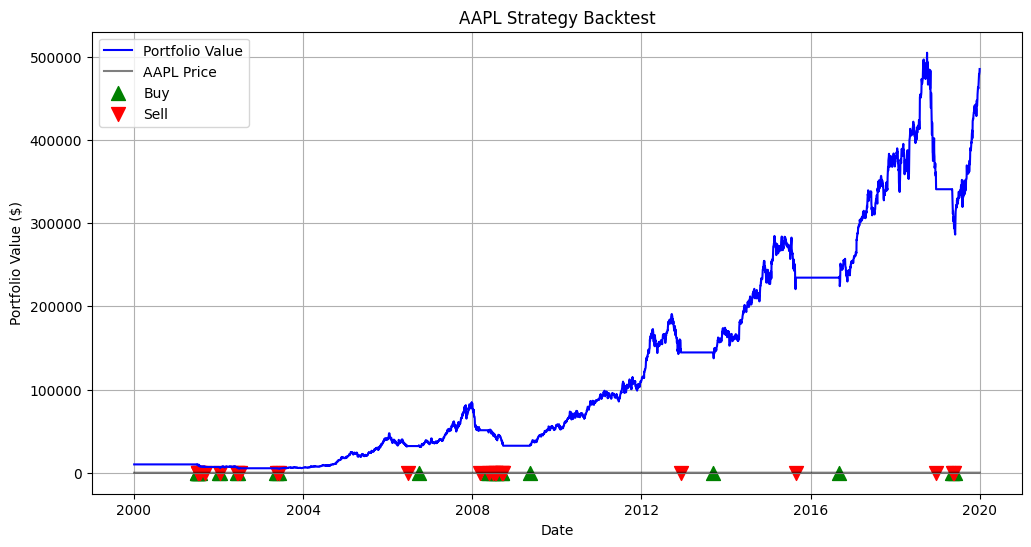

In [4]:
# Download historical stock data
def get_data(stock_symbol, start, end):
    """
    Downloads historical stock data from Yahoo Finance.
    :param stock_symbol: The ticker symbol of the stock (e.g., 'AAPL').
    :param start: The start date for the data (YYYY-MM-DD).
    :param end: The end date for the data (YYYY-MM-DD).
    :return: A pandas DataFrame containing the stock data with moving averages.
    """
    print(f"\nFetching data for {stock_symbol} from {start} to {end}...")
    data = yf.download(stock_symbol, start=start, end=end)
    data['50_MA'] = data['Close'].rolling(window=50).mean()
    data['200_MA'] = data['Close'].rolling(window=200).mean()
    print("Data download complete!\n")
    return data

# Backtesting strategy with prediction accuracy
def backtest_strategy(data, initial_balance=10000, transaction_cost=0.001, stop_loss=0.05):
    """
    Simulates trading based on the Moving Average Crossover strategy and calculates accuracy.
    :param data: The stock price data with calculated moving averages.
    :param initial_balance: The starting capital.
    :param transaction_cost: Transaction fee as a percentage of trade size.
    :param stop_loss: The maximum loss threshold after entering a position (e.g., 0.05 = 5%).
    :return: The final balance, total return, portfolio history, buy/sell signal locations, and prediction accuracy.
    """
    print("Backtesting the strategy...\n")
    balance = initial_balance
    shares = 0
    buy_price = 0
    history = []
    buy_signals = []
    sell_signals = []
    correct_predictions = 0  # To track correct buy/sell predictions
    total_predictions = 0  # To track total number of buy/sell signals
    
    for i in range(len(data)):
        # Check for buy signal (50-day MA crosses above 200-day MA)
        if data['50_MA'].iloc[i] > data['200_MA'].iloc[i] and shares == 0:
            shares = balance // data['Close'].iloc[i]
            balance -= shares * data['Close'].iloc[i] * (1 + transaction_cost)
            buy_price = data['Close'].iloc[i]
            buy_signals.append((data.index[i], data['Close'].iloc[i]))  # Log buy point
            total_predictions += 1  # Add to the total predictions count
            
            # Check if the stock price increased within 5 days after the buy
            if i + 5 < len(data) and data['Close'].iloc[i + 5] > data['Close'].iloc[i]:
                correct_predictions += 1  # Correct buy prediction

        # Check for sell signal (50-day MA crosses below 200-day MA)
        elif data['50_MA'].iloc[i] < data['200_MA'].iloc[i] and shares > 0:
            balance += shares * data['Close'].iloc[i] * (1 - transaction_cost)
            shares = 0
            sell_signals.append((data.index[i], data['Close'].iloc[i]))  # Log sell point
            total_predictions += 1  # Add to the total predictions count
            
            # Check if the stock price decreased within 5 days after the sell
            if i + 5 < len(data) and data['Close'].iloc[i + 5] < data['Close'].iloc[i]:
                correct_predictions += 1  # Correct sell prediction

        # Implement stop-loss to limit losses
        if shares > 0 and (data['Close'].iloc[i] < buy_price * (1 - stop_loss)):
            balance += shares * data['Close'].iloc[i] * (1 - transaction_cost)
            shares = 0
            sell_signals.append((data.index[i], data['Close'].iloc[i]))  # Log forced sell by stop-loss
        
        # Log the portfolio value for performance tracking
        portfolio_value = balance + shares * data['Close'].iloc[i]
        history.append(portfolio_value)

    # Calculate final balance, total return, and signal history
    final_balance = balance + shares * data['Close'].iloc[-1]
    total_return = (final_balance - initial_balance) / initial_balance * 100

    # Calculate prediction accuracy
    accuracy = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0

    return final_balance, total_return, history, buy_signals, sell_signals, accuracy


# Calculate Sharpe Ratio
def calculate_sharpe_ratio(returns, risk_free_rate=0):
    """
    Calculates the Sharpe ratio to measure risk-adjusted return.
    :param returns: Daily returns of the portfolio.
    :param risk_free_rate: The risk-free rate of return (e.g., treasury bonds).
    :return: The Sharpe ratio.
    """
    excess_returns = np.array(returns) - risk_free_rate
    return np.mean(excess_returns)
    / np.std(excess_returns)

# Calculate Max Drawdown
def calculate_max_drawdown(history):
    """
    Calculates the maximum drawdown (biggest peak-to-trough drop).
    :param history: The portfolio value over time.
    :return: The maximum drawdown.
    """
    peak = history[0]
    max_drawdown = 0
    for value in history:
        if value > peak:
            peak = value
        drawdown = (peak - value) / peak
        if drawdown > max_drawdown:
            max_drawdown = drawdown
    return max_drawdown

# Calculate Compound Annual Growth Rate (CAGR)
def calculate_cagr(initial_value, final_value, periods):
    """
    Calculates the CAGR of the portfolio.
    :param initial_value: Starting value of the portfolio.
    :param final_value: Ending value of the portfolio.
    :param periods: Total time periods (in years).
    :return: The CAGR.
    """
    return (final_value / initial_value) ** (1 / periods) - 1

# Plot strategy performance with buy/sell markers and fixed legend
def plot_performance(data, history, buy_signals, sell_signals, stock_symbol):
    """
    Plots the portfolio performance and stock price with buy/sell points.
    :param data: Stock price data.
    :param history: Portfolio value over time.
    :param buy_signals: List of buy points.
    :param sell_signals: List of sell points.
    :param stock_symbol: The stock ticker symbol.
    """
    plt.figure(figsize=(12, 6))
    
    # Plot portfolio value
    plt.plot(data.index, history, label='Portfolio Value', color='blue')
    
    # Plot stock price
    plt.plot(data.index, data['Close'], label=f'{stock_symbol} Price', color='black', alpha=0.5)
    
    # Mark buy and sell points (plot just one for legend)
    if buy_signals:
        plt.scatter(buy_signals[0][0], buy_signals[0][1], marker='^', color='green', label='Buy', s=100)
    if sell_signals:
        plt.scatter(sell_signals[0][0], sell_signals[0][1], marker='v', color='red', label='Sell', s=100)
    
    # Plot the rest of the buy and sell points (without adding to legend)
    for signal in buy_signals:
        plt.scatter(signal[0], signal[1], marker='^', color='green', s=100)
    
    for signal in sell_signals:
        plt.scatter(signal[0], signal[1], marker='v', color='red', s=100)
    
    # Title and labels
    plt.title(f'{stock_symbol} Strategy Backtest')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    
    # Display the legend with one green and one red arrow
    plt.legend()
    
    # Display the grid
    plt.grid(True)
    
    # Show the plot
    plt.show()


def main():
    # User inputs for ticker symbol, start date, and end date
    stock_symbol = input("Enter the stock ticker symbol (e.g., AAPL): ").upper()
    start_date = input("Enter the start date (YYYY-MM-DD): ")
    end_date = input("Enter the end date (YYYY-MM-DD): ")
    initial_balance = float(input("Enter the initial investment amount ($): "))

    # Get stock data
    data = get_data(stock_symbol, start=start_date, end=end_date)

    # Run backtest with transaction cost and stop-loss
    final_balance, total_return, history, buy_signals, sell_signals, accuracy = backtest_strategy(data, initial_balance)

    # Performance metrics
    daily_returns = np.diff(history) / history[:-1]
    sharpe_ratio = calculate_sharpe_ratio(daily_returns)
    max_drawdown = calculate_max_drawdown(history)
    cagr = calculate_cagr(initial_balance, final_balance, periods=(len(data) / 252))  # Assume 252 trading days/year

    # Output performance metrics with explanations
    print(f"\n=== Strategy Performance for {stock_symbol} ===")
    print(f"Initial Investment: ${initial_balance:,.2f}")
    print(f"Final Portfolio Value: ${final_balance:,.2f}")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f} (Higher is better; >1 is considered good)")
    print(f"Max Drawdown: {max_drawdown:.2f}% (Maximum loss from a peak to a trough)")
    print(f"CAGR: {cagr:.2f} (Annualized growth rate over the period)\n")
    print(f"Prediction Accuracy: {accuracy:.2f}% (Correct buy/sell predictions)\n")

    # Plot performance
    plot_performance(data, history, buy_signals, sell_signals, stock_symbol)

if __name__ == '__main__':
    main()
